Neste notebook tem o objetivo de transformar os videos em tensores

primeiro ler o xlsx e criar um dicionario com key VIDEO

In [2]:
import os
import pandas as pd
import cv2
from PIL import Image
import numpy as np
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import random
from PIL import Image


VIDEO_PATH = "data/Package01"
EXCEL_PATH = "data/OSATS.xlsx"

In [3]:
excel_file = pd.read_excel(EXCEL_PATH)
excel_file


,STUDENT,GROUP,TIME,SUTURES,INVESTIGATOR,VIDEO,OSATS_RESPECT,OSATS_MOTION,OSATS_INSTRUMENT,OSATS_SUTURE,OSATS_FLOW,OSATS_KNOWLEDGE,OSATS_PERFORMANCE,OSATS_FINAL_QUALITY,GLOBA_RATING_SCORE
0,AHO729,E-LEARNING,PRE,1.0,A,P54M,2,1,2,2,1,2,2,1,13
1,AHO729,E-LEARNING,PRE,1.0,B,P54M,2,1,3,1,2,1,2,1,13
2,AHO729,E-LEARNING,PRE,1.0,C,P54M,2,1,1,1,1,1,1,1,9
3,AHO729,E-LEARNING,POST,4.5,A,M45P,4,4,4,3,3,4,3,3,28
4,AHO729,E-LEARNING,POST,4.5,B,M45P,2,3,4,3,3,4,3,3,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
937,ZWO108,HMD-BASED,PRE,0.5,B,D94Z,1,1,2,1,1,1,1,1,9
938,ZWO108,HMD-BASED,PRE,0.5,C,D94Z,1,1,1,1,2,1,1,1,9
939,ZWO108,HMD-BASED,POST,3.0,A,Z49D,4,3,3,3,3,3,3,3,25
940,ZWO108,HMD-BASED,POST,3.0,B,Z49D,4,3,4,4,4,5,4,5,33


In [4]:
def class_grs(grs):
    if 8 <= grs <= 15:
        return 0  # novice
    elif 16 <= grs <= 23:
        return 1  # intermediate
    elif 24 <= grs <= 31:
        return 2  # proeficient
    elif 32 <= grs <= 40:
        return 3  # specialist
    else:
        return -1  # GRS not in range

excel_file['GRS'] = excel_file['GLOBA_RATING_SCORE'].apply(class_grs)

In [5]:
def get_classes():
    with open("data/classes.txt") as fich_labels:
        labels = fich_labels.read().split()
        classes = dict(zip(labels, list(range(len(labels)))))
    return classes
dic_classes=get_classes()
print(dic_classes)

{'novice': 0, 'intermediate': 1, 'proeficient': 2, 'specialist': 3}


In [6]:


def criar_excel_limpo(videos_path, excel_path, output_excel="OSATS_clean.xlsx"):
    """
    Cria um arquivo Excel contendo apenas as colunas 'VIDEO' e 'GRS' para os vídeos
    que estão presentes na pasta especificada. Cada vídeo aparece apenas uma vez,
    com a média das classificações calculada e a classe correspondente gerada.
    
    Args:
        videos_path (str): Caminho para a pasta contendo os vídeos.
        excel_path (str): Caminho para o arquivo OSATS.xlsx.
        output_excel (str): Nome do arquivo Excel de saída.
    """
    # Verificar se os caminhos existem
    if not os.path.exists(videos_path):
        raise FileNotFoundError(f"Pasta de vídeos não encontrada: {videos_path}")
    
    if not os.path.exists(excel_path):
        raise FileNotFoundError(f"Arquivo Excel não encontrado: {excel_path}")
    
    # Carregar o arquivo Excel
    df = pd.read_excel(excel_path)
    
    # Listar todos os arquivos de vídeo na pasta
    video_extensions = ('.mp4',)
    videos = [os.path.splitext(f)[0] for f in os.listdir(videos_path) if f.lower().endswith(video_extensions)]
    
    # Filtrar o DataFrame para conter apenas os vídeos presentes na pasta
    df_filtered = df[df['VIDEO'].isin(videos)]
    
    # Calcular a média do GLOBA_RATING_SCORE para cada vídeo
    df_mean = df_filtered.groupby('VIDEO')['GLOBA_RATING_SCORE'].mean().reset_index()
    
    # Adicionar a coluna 'GRS' com a classificação baseada na média
    df_mean['GRS'] = df_mean['GLOBA_RATING_SCORE'].apply(class_grs)
    
    # Selecionar apenas as colunas 'VIDEO' e 'GRS'
    df_clean = df_mean[['VIDEO', 'GRS']]
    
    # Salvar o novo Excel
    df_clean.to_excel(output_excel, index=False)
    print(f"Arquivo '{output_excel}' criado com sucesso!")



In [7]:
# Exemplo de uso
criar_excel_limpo(VIDEO_PATH, EXCEL_PATH)

clean_excel_file = pd.read_excel("OSATS_clean.xlsx")
clean_excel_file




Arquivo 'OSATS_clean.xlsx' criado com sucesso!


,VIDEO,GRS
0,A31H,0
1,A40E,1
2,A41X,3
3,A61V,2
4,A80U,0
5,A83X,2
6,A92O,1
7,B12G,0
8,B61D,0
9,C16G,1


## EXTRAIR FRAMSES

In [8]:
def extrair_frames(video_path, output_dir, frame_rate=10, frame_size=(224, 224)):
    """
    Extrai frames de um vídeo, redimensiona e os salva em uma pasta.

    Args:
        video_path (str): Caminho para o arquivo de vídeo.
        output_dir (str): Diretório onde os frames serão salvos.
        frame_rate (int): Taxa de quadros (frames) a serem extraídos por segundo.
        frame_size (tuple): Resolução desejada dos frames (largura, altura).
    """
    # Verificar se a pasta já existe
    if os.path.exists(output_dir):
        print(f"Pasta '{output_dir}' já existe. Saltando este vídeo.")
        return

    os.makedirs(output_dir, exist_ok=True)
    cap = cv2.VideoCapture(video_path)
    count = 0
    frame_count = 0

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        # Salvar apenas frames na taxa especificada
        if count % frame_rate == 0:
            # Redimensionar o frame para a resolução desejada
            resized_frame = cv2.resize(frame, frame_size)
            frame_path = os.path.join(output_dir, f"frame_{frame_count:04d}.jpg")
            cv2.imwrite(frame_path, resized_frame)
            frame_count += 1
        count += 1

    cap.release()
    print(f"Frames extraídos de {video_path} e salvos em {output_dir}")

In [9]:
output_base_dir = "frames"  # Pasta onde os frames serão salvos

for video_file in os.listdir(VIDEO_PATH):
    if video_file.endswith(('.mp4')):
        video_path = os.path.join(VIDEO_PATH, video_file)
        output_dir = os.path.join(output_base_dir, os.path.splitext(video_file)[0])
        extrair_frames(video_path, output_dir, frame_rate=10, frame_size=(224, 224))

Pasta 'frames/C28D' já existe. Saltando este vídeo.
Pasta 'frames/B12G' já existe. Saltando este vídeo.
Pasta 'frames/A61V' já existe. Saltando este vídeo.
Pasta 'frames/C56Y' já existe. Saltando este vídeo.
Pasta 'frames/B61D' já existe. Saltando este vídeo.
Pasta 'frames/C43T' já existe. Saltando este vídeo.
Pasta 'frames/C42I' já existe. Saltando este vídeo.
Pasta 'frames/A41X' já existe. Saltando este vídeo.
Pasta 'frames/C16G' já existe. Saltando este vídeo.
Pasta 'frames/A92O' já existe. Saltando este vídeo.
Pasta 'frames/C58C' já existe. Saltando este vídeo.
Pasta 'frames/A80U' já existe. Saltando este vídeo.
Pasta 'frames/A40E' já existe. Saltando este vídeo.
Pasta 'frames/A83X' já existe. Saltando este vídeo.
Pasta 'frames/A31H' já existe. Saltando este vídeo.


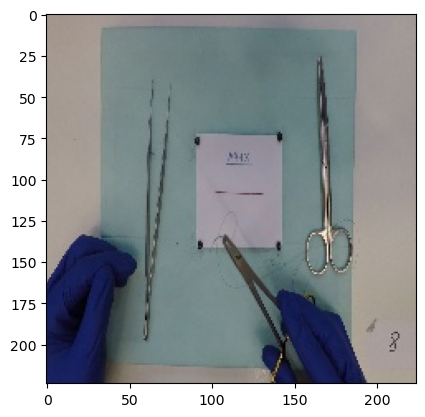

In [10]:
image = "frames/A41X/frame_0000.jpg"
image = cv2.imread(image)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
import matplotlib.pyplot as plt
plt.imshow(image)

Calcular Media e Desvio Padrão

In [11]:

class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Dataset para carregar imagens de uma pasta.

        Args:
            root_dir (str): Diretório raiz contendo as pastas de imagens.
            transform (callable, optional): Transformação a ser aplicada nas imagens.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        
        # Coleta todos os caminhos das imagens nas subpastas
        for subdir, _, files in os.walk(root_dir):
            for file in files:
                if file.endswith(('.jpg', '.png', '.jpeg')):
                    self.image_paths.append(os.path.join(subdir, file))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')  # Converte para RGB
        if self.transform:
            image = self.transform(image)
        return image

def calculate_mean_std(root_dir):
    # Caminho para a pasta com as imagens
    root_dir = "frames"  # Substitua pelo caminho correto
    
    # Dataset com transformação inicial para tensor
    transform = ToTensor()  # Converte para tensor com valores entre [0, 1]
    dataset = ImageDataset(root_dir, transform=transform)
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    
    # Inicializa somas e contadores
    mean = 0.0
    std = 0.0
    n_samples = 0
    
    for images in loader:
        batch_samples = images.size(0)  # Número de imagens no batch
        images = images.view(batch_samples, images.size(1), -1)  # Achata os pixels
        mean += images.mean(2).sum(0)  # Soma a média de cada canal
        std += images.std(2).sum(0)    # Soma o desvio padrão de cada canal
        n_samples += batch_samples
    
    mean /= n_samples
    std /= n_samples
    
    print(f"Mean: {mean}")
    print(f"Std: {std}")

Results: 

Mean: tensor([0.4407, 0.4776, 0.5026])

Std: tensor([0.1906, 0.1620, 0.1209])

In [12]:
mean = [0.4407, 0.4776, 0.5026]  
std =[0.1906, 0.1620, 0.1209]  

transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),         
    transforms.Normalize(mean=mean, std=std)  
    
])


In [13]:


# Caminhos
ROOT_DIR = "frames"  # Pasta com os frames
LABELS_FILE = "OSATS_clean.xlsx"  # Arquivo com os rótulos

# Proporções para divisão
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Transformações
mean = [0.4407, 0.4776, 0.5026]
std = [0.1906, 0.1620, 0.1209]
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# Dataset customizado
class VideoFrameDataset(Dataset):
    def __init__(self, root_dir, labels_file, video_ids, transform=None):
        """
        Dataset para carregar frames de vídeos e suas respectivas classes.

        Args:
            root_dir (str): Diretório raiz contendo as pastas de frames.
            labels_file (str): Caminho para o arquivo Excel com as classes.
            video_ids (list): Lista de IDs de vídeos a serem incluídos.
            transform (callable, optional): Transformação a ser aplicada nas imagens.
        """
        self.root_dir = root_dir
        self.labels = pd.read_excel(labels_file)
        self.video_ids = video_ids
        self.transform = transform
        self.data = []

        # Filtrar os dados com base nos IDs de vídeos
        for video_id in self.video_ids:
            video_frames_dir = os.path.join(self.root_dir, video_id)
            if os.path.exists(video_frames_dir):
                for frame_file in os.listdir(video_frames_dir):
                    if frame_file.endswith(('.jpg', '.png', '.jpeg')):
                        frame_path = os.path.join(video_frames_dir, frame_file)
                        label = self.labels.loc[self.labels['VIDEO'] == video_id, 'GRS'].values[0]
                        self.data.append((frame_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        frame_path, label = self.data[idx]
        image = Image.open(frame_path)
        if self.transform:
            image = self.transform(image)
        return image, label

# Função para dividir os dados por vídeo
def split_data_by_video(root_dir, train_ratio, val_ratio, test_ratio):
    # Listar todas as pastas (IDs de vídeos)
    video_ids = [folder for folder in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, folder))]
    random.shuffle(video_ids)  # Embaralhar os IDs

    # Calcular tamanhos
    total_videos = len(video_ids)
    train_size = int(total_videos * train_ratio)
    val_size = int(total_videos * val_ratio)

    # Dividir os IDs
    train_ids = video_ids[:train_size]
    val_ids = video_ids[train_size:train_size + val_size]
    test_ids = video_ids[train_size + val_size:]

    return train_ids, val_ids, test_ids

# Criar DataLoaders
def create_dataloaders(root_dir, labels_file, train_ids, val_ids, test_ids, transform, batch_size=32):
    train_dataset = VideoFrameDataset(root_dir, labels_file, train_ids, transform)
    val_dataset = VideoFrameDataset(root_dir, labels_file, val_ids, transform)
    test_dataset = VideoFrameDataset(root_dir, labels_file, test_ids, transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

# Dividir os dados por vídeo
train_ids, val_ids, test_ids = split_data_by_video(ROOT_DIR, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

# Criar os DataLoaders
train_loader, val_loader, test_loader = create_dataloaders(ROOT_DIR, LABELS_FILE, train_ids, val_ids, test_ids, transform)

# Exemplo: verificar tamanhos
print(f"Treino: {len(train_loader.dataset)} frames")
print(f"Validação: {len(val_loader.dataset)} frames")
print(f"Teste: {len(test_loader.dataset)} frames")

Treino: 9029 frames
Validação: 1822 frames
Teste: 2757 frames


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.396438590958951e-08..0.9882353430271148].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.396438590958951e-08..0.9686274600028991].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.396438590958951e-08..1.0000000183105469].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.396438590958951e-08..0.8784313889503479].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.396438590958951e-08..0.9764706223011016].


Visualizando dados de treino:


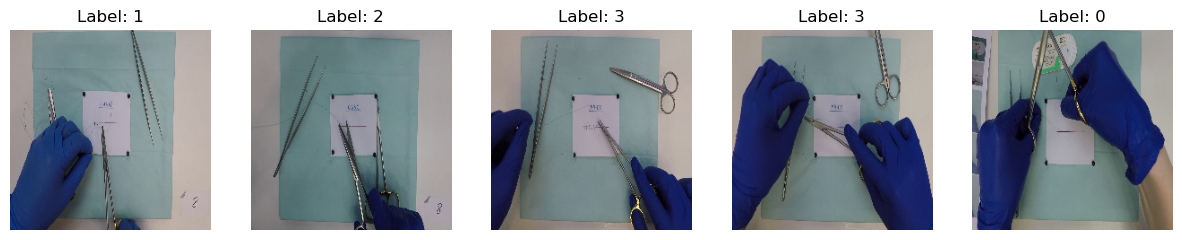

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.396438590958951e-08..1.0000000183105469].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.396438590958951e-08..0.972549063873291].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.396438590958951e-08..1.0000000183105469].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.396438590958951e-08..1.0000000183105469].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.396438590958951e-08..1.0000000183105469].


Visualizando dados de validação:


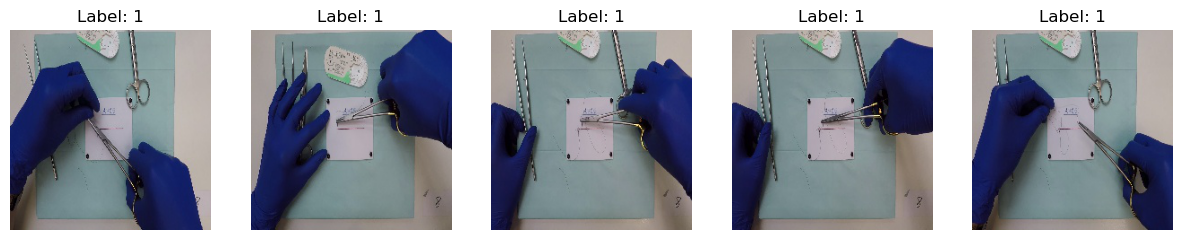

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6450881934471084e-08..1.0000000183105469].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.396438590958951e-08..1.0000000183105469].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6450881934471084e-08..0.894117657661438].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6450881934471084e-08..0.9137255014896393].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.396438590958951e-08..1.0000000183105469].


Visualizando dados de teste:


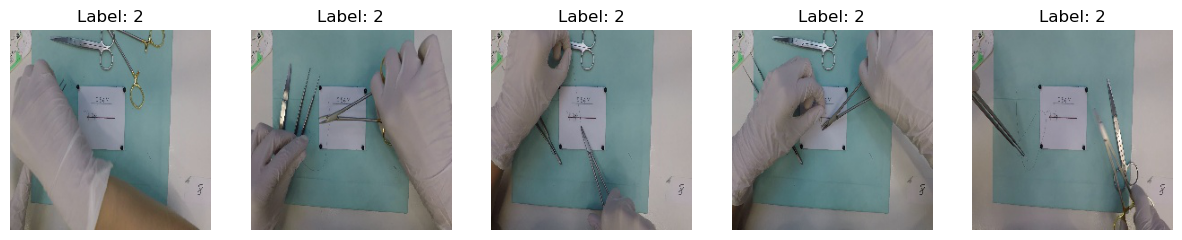

In [14]:

def visualize_data(loader, num_images=5):
    """
    Visualiza algumas imagens e seus rótulos de um DataLoader.

    Args:
        loader (DataLoader): O DataLoader de onde as imagens serão retiradas.
        num_images (int): Número de imagens a serem exibidas.
    """
    # Obter um batch de dados do DataLoader
    images, labels = next(iter(loader))
    
    # Exibir as primeiras `num_images` imagens
    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.axis('off')
        plt.imshow(images[i].permute(1, 2, 0).numpy() * std + mean)  # Desnormalizar para exibir
        plt.title(f"Label: {labels[i].item()}")
    plt.show()

# Visualizar dados de treino
print("Visualizando dados de treino:")
visualize_data(train_loader)

# Visualizar dados de validação
print("Visualizando dados de validação:")
visualize_data(val_loader)

# Visualizar dados de teste
print("Visualizando dados de teste:")
visualize_data(test_loader)

In [15]:

def visualize_dataset_split(train_loader, val_loader, test_loader):
    """
    Visualiza informações sobre a divisão dos dados em treino, validação e teste.

    Args:
        train_loader (DataLoader): DataLoader para o conjunto de treino.
        val_loader (DataLoader): DataLoader para o conjunto de validação.
        test_loader (DataLoader): DataLoader para o conjunto de teste.
    """
    print(f"Quantidade de casos de Treino: {len(train_loader.dataset)}")
    print(f"Quantidade de casos de Validação: {len(val_loader.dataset)}")
    print(f"Quantidade de casos de Teste: {len(test_loader.dataset)}")
    
    # Visualizar um batch de cada DataLoader
    for loader, name in zip([train_loader, val_loader, test_loader], ["Treino", "Validação", "Teste"]):
        x, y = next(iter(loader))  # Obter um batch
        print(f"\n{name}:")
        print(f"Shape tensor batch, input: {x.shape}, output: {y.shape}")
        print(f"Valor máximo no batch: {torch.max(x)} Valor mínimo no batch: {torch.min(x)}")
        x = x.detach().numpy()
        print(f"Valor máximo após conversão para numpy: {np.max(x)} Valor mínimo: {np.min(x)}")
        print(f"Rótulos no batch: {y}")

# Exemplo de uso
visualize_dataset_split(train_loader, val_loader, test_loader)

Quantidade de casos de Treino: 9029
Quantidade de casos de Validação: 1822
Quantidade de casos de Teste: 2757

Treino:
Shape tensor batch, input: torch.Size([32, 3, 224, 224]), output: torch.Size([32])
Valor máximo no batch: 4.1141438484191895 Valor mínimo no batch: -4.1571550369262695
Valor máximo após conversão para numpy: 4.1141438484191895 Valor mínimo: -4.1571550369262695
Rótulos no batch: tensor([0, 3, 0, 0, 0, 1, 2, 1, 0, 2, 0, 0, 2, 0, 2, 0, 1, 0, 1, 0, 0, 0, 0, 1,
        0, 2, 0, 0, 2, 0, 3, 2])

Validação:
Shape tensor batch, input: torch.Size([32, 3, 224, 224]), output: torch.Size([32])
Valor máximo no batch: 4.1141438484191895 Valor mínimo no batch: -4.1571550369262695
Valor máximo após conversão para numpy: 4.1141438484191895 Valor mínimo: -4.1571550369262695
Rótulos no batch: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1])

Teste:
Shape tensor batch, input: torch.Size([32, 3, 224, 224]), output: torch.Size(

-----------------------------------Treino-----------------------------------


Total de casos em Treino: 9029
Classes: [0 1 2 3]
Frequências: [4554 1725 1835  915]
Total: 9029


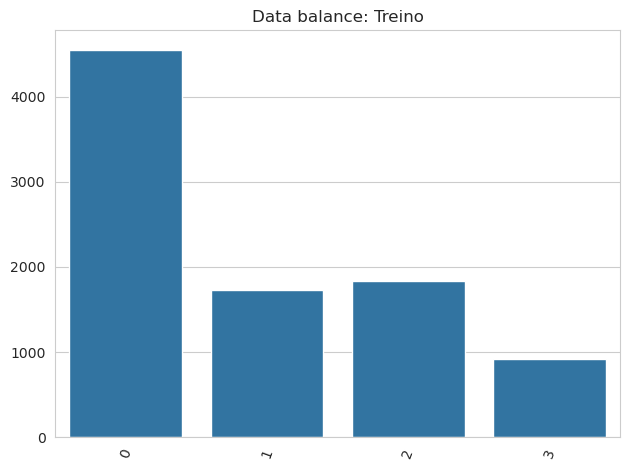

-----------------------------------Validação-----------------------------------
Total de casos em Validação: 1822
Classes: [0 1]
Frequências: [908 914]
Total: 1822


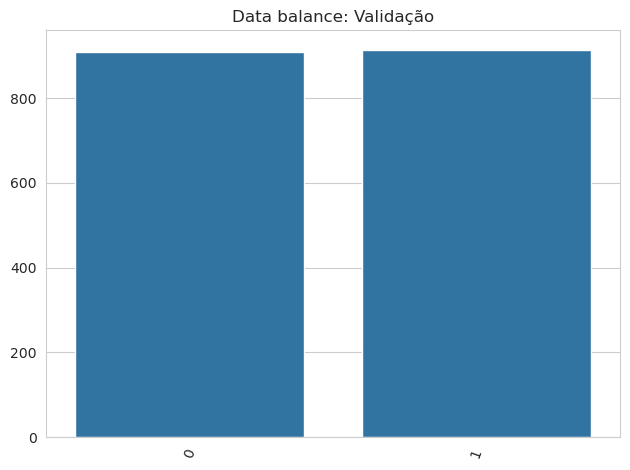

-----------------------------------Teste-----------------------------------
Total de casos em Teste: 2757
Classes: [0 2]
Frequências: [ 912 1845]
Total: 2757


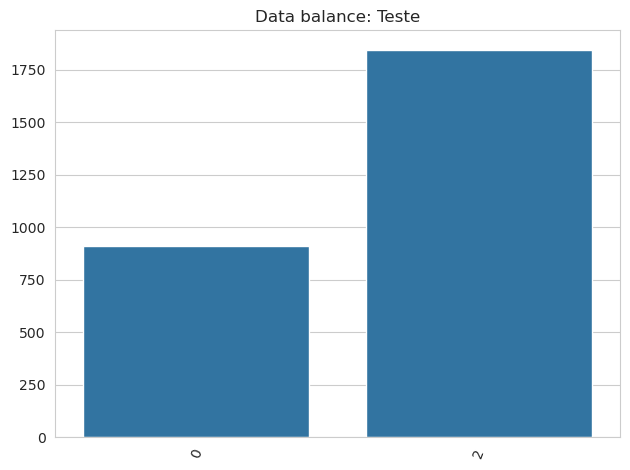

In [16]:


def visualize_data_balance(loader, titulo):
    """
    Visualiza o balanceamento dos dados em um DataLoader.

    Args:
        loader (DataLoader): DataLoader para o conjunto de dados.
        titulo (str): Título do gráfico.
        dic_classes (dict): Dicionário de mapeamento de classes (ex.: {0: "novice", 1: "intermediate", ...}).
    """
    # Obter todos os rótulos do DataLoader
    all_labels = []
    for _, labels in loader:
        all_labels.extend(labels.numpy())
    
    sns.set_style('whitegrid')
    print(f"Total de casos em {titulo}: {len(all_labels)}")
    
    # Contar a frequência de cada classe
    x, y = np.unique(all_labels, return_counts=True)
    
    print("Classes:", x)
    print("Frequências:", y)
    print("Total:", np.sum(y))
    
    # Criar o gráfico de barras
    grafico = sns.barplot(x=x, y=y)
    grafico.set_title(f'Data balance: {titulo}')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show()

# Exemplo de uso
print("-----------------------------------Treino-----------------------------------")
visualize_data_balance(train_loader, 'Treino')

print("-----------------------------------Validação-----------------------------------")
visualize_data_balance(val_loader, 'Validação')

print("-----------------------------------Teste-----------------------------------")
visualize_data_balance(test_loader, 'Teste')

-----------------------------------Treino-----------------------------------
Total de vídeos em Treino: 10


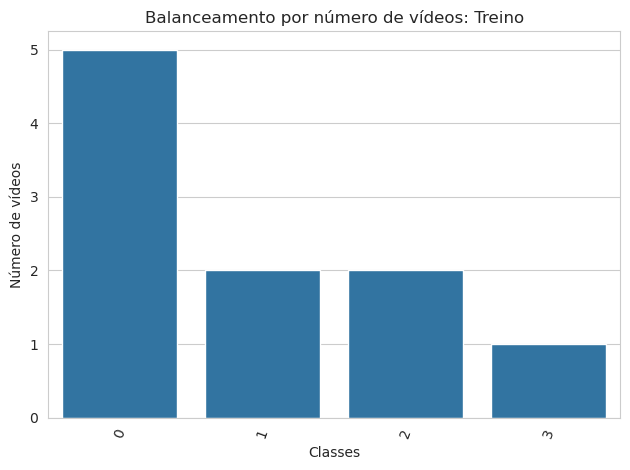

-----------------------------------Validação-----------------------------------
Total de vídeos em Validação: 2


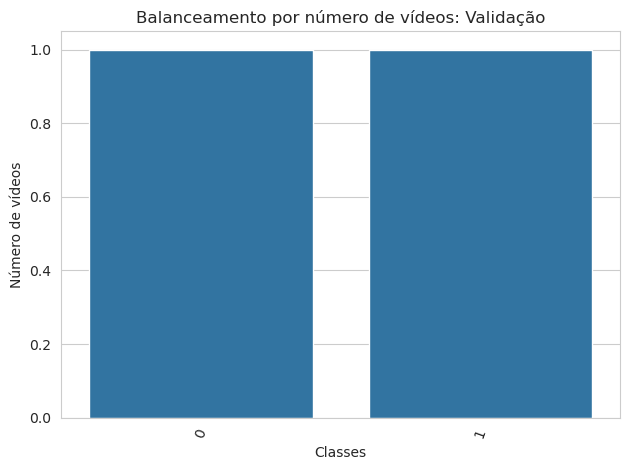

-----------------------------------Teste-----------------------------------
Total de vídeos em Teste: 3


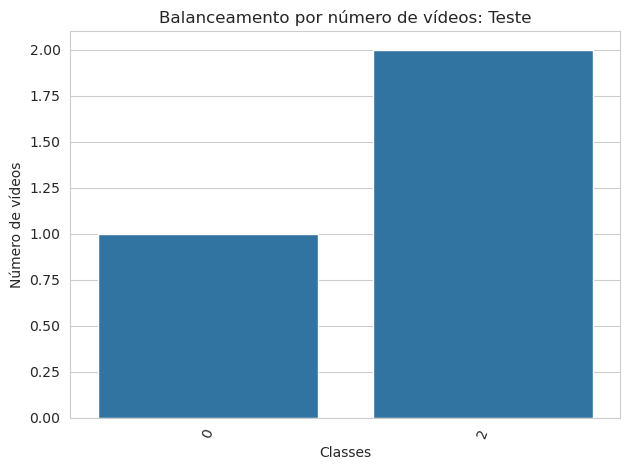

In [17]:


def visualize_video_balance(video_ids, labels_file, titulo):
    """
    Visualiza o balanceamento dos dados em termos de número de vídeos por classe.

    Args:
        video_ids (list): Lista de IDs de vídeos.
        labels_file (str): Caminho para o arquivo Excel com os rótulos.
        titulo (str): Título do gráfico.
    """
    # Carregar os rótulos do arquivo Excel
    labels_df = pd.read_excel(labels_file)
    
    # Filtrar os rótulos para os vídeos fornecidos
    filtered_labels = labels_df[labels_df['VIDEO'].isin(video_ids)]
    
    # Contar o número de vídeos por classe
    class_counts = filtered_labels['GRS'].value_counts().sort_index()
    
    sns.set_style('whitegrid')
    print(f"Total de vídeos em {titulo}: {len(video_ids)}")
    
    # Criar o gráfico de barras
    grafico = sns.barplot(x=class_counts.index, y=class_counts.values)
    grafico.set_title(f'Balanceamento por número de vídeos: {titulo}')
    grafico.set_xlabel('Classes')
    grafico.set_ylabel('Número de vídeos')
    plt.xticks(rotation=70)
    plt.tight_layout()
    plt.show()

# Exemplo de uso
print("-----------------------------------Treino-----------------------------------")
visualize_video_balance(train_ids, LABELS_FILE, 'Treino')

print("-----------------------------------Validação-----------------------------------")
visualize_video_balance(val_ids, LABELS_FILE, 'Validação')

print("-----------------------------------Teste-----------------------------------")
visualize_video_balance(test_ids, LABELS_FILE, 'Teste')